# Domain Name Trends: Popularity & Pricing of `.io` and Other Alt-TLDs


### Research Question: **What is the popularity trend timeline for `.io` and other "trendy" alt-TLDs?**  

---

### Methods & Data Sources

To find an answer, we use both:

- Certificate Transparency Data via [`crt.sh`](https://crt.sh/)
- Domain Sale Price Data via [a paid Whois API](https://apilayer.com/marketplace/whois-api)


# Step 1: Choosing a Set of Domain Names for Each TLD

We'll start by digging into [Cisco's top 1-Million domains](https://s3-us-west-1.amazonaws.com/umbrella-static/index.html) list to select cohorts of about 1,000 domains for each TLD of interest. We'll aim for a good mix of popular and less popular domains in each.

In [1]:
### TLDs of interest
og_tlds = ["com", "net", "org"]
alt_tlds = ["io", "ai", "co", "me", "tv", "biz"]

In [3]:
import pandas as pd

# Load the dataset
top_domains_df = pd.read_csv("data/cisco-top-1m.csv", names=["rank", "domain"])

# Preview
top_domains_df.head()


,rank,domain
0,1,google.com
1,2,microsoft.com
2,3,data.microsoft.com
3,4,e2ro.com
4,5,node.e2ro.com


In [4]:
def get_tld(domain):
    return domain.split(".")[-1]

top_domains_df["tld"] = top_domains_df["domain"].apply(get_tld)
top_domains_df.head()

,rank,domain,tld
0,1,google.com,com
1,2,microsoft.com,com
2,3,data.microsoft.com,com
3,4,e2ro.com,com
4,5,node.e2ro.com,com


In [5]:
# Print counts for each of our TLDs of interest
all_tlds = og_tlds + alt_tlds
filtered = top_domains_df[top_domains_df["tld"].isin(all_tlds)]
counts = filtered["tld"].value_counts().reindex(all_tlds, fill_value=0)
counts_df = counts.reset_index()
counts_df.columns = ["TLD", "Count"]
counts_df

,TLD,Count
0,com,583019
1,net,152577
2,org,27546
3,io,28358
4,ai,2821
5,co,5585
6,me,3610
7,tv,4473
8,biz,1220


In [ ]:
# We want to filter out all of the infra subdomains 
# to get a clearer picture of how many individual companies
# are actually using these domains

import tldextract

# Add eTLD+1 (root domain) column
top_domains_df["root_domain"] = top_domains_df["domain"].apply(
    lambda d: f"{tldextract.extract(d).domain}.{tldextract.extract(d).suffix}"
)

# Define unwanted infrastructure keywords
infra_keywords = ["cdn", "ads", "akamai", "edge", "sdk", "analytics", "api", "gateway", "internal", "tooling", "uat", "metrics"]

def is_infra(domain):
    return any(kw in domain.lower() for kw in infra_keywords)

# Filter out infrastructure and drop duplicate root domains
filtered_top_domains_df = top_domains_df[~top_domains_df["domain"].apply(is_infra)].copy()
filtered_top_domains_df = filtered_top_domains_df.drop_duplicates("root_domain")


,rank,domain,tld,root_domain,cohort
0,1,google.com,com,google.com,top
1,2,microsoft.com,com,microsoft.com,top
2,4,e2ro.com,com,e2ro.com,top
3,7,windowsupdate.com,com,windowsupdate.com,top
4,10,office.com,com,office.com,top


In [ ]:
# Print counts for each TLD after filtering out infra subdomains
all_tlds = og_tlds + alt_tlds
filtered = filtered_top_domains_df[filtered_top_domains_df["tld"].isin(all_tlds)]
counts = filtered["tld"].value_counts().reindex(all_tlds, fill_value=0)
counts_df = counts.reset_index()
counts_df.columns = ["TLD", "Count"]
counts_df

,TLD,Count
0,com,99829
1,net,11704
2,org,7862
3,io,4299
4,ai,992
5,co,1828
6,me,1002
7,tv,714
8,biz,618


In [14]:
import random

# Parameters
target_total = 1000       # Max total per TLD
num_top = 100             # Fixed top N per TLD
top_samples = []
random_samples = []

for tld in all_tlds:
    tld_df = filtered_top_domains_df[filtered_top_domains_df["tld"] == tld].copy()
    tld_df_sorted = tld_df.sort_values("rank")
    
    total_available = len(tld_df_sorted)
    use_all = total_available <= target_total

    if use_all:
        # Just use everything available
        full_df = tld_df_sorted.copy()
        top_n_df = full_df.head(min(num_top, total_available)).copy()
        remaining_df = full_df.iloc[len(top_n_df):]
        random_df = remaining_df.copy()
    else:
        # Standard case: limit to top + random
        top_n_df = tld_df_sorted.head(num_top).copy()
        remaining_df = tld_df_sorted.iloc[num_top:]
        random_n = target_total - num_top
        random_df = remaining_df.sample(n=random_n, random_state=42).copy()

    top_n_df["cohort"] = "top"
    random_df["cohort"] = "random"

    top_samples.append(top_n_df)
    random_samples.append(random_df)

# Combine final result
final_domains = pd.concat(top_samples + random_samples).reset_index(drop=True)

# Preview
final_domains.head()


,rank,domain,tld,root_domain,cohort
0,1,google.com,com,google.com,top
1,2,microsoft.com,com,microsoft.com,top
2,4,e2ro.com,com,e2ro.com,top
3,7,windowsupdate.com,com,windowsupdate.com,top
4,10,office.com,com,office.com,top


In [15]:
# Number of domains per TLD to display
n_per_tld = 10

# Create dictionary: {tld: [list of domains]}
tld_columns = {
    tld: final_domains[final_domains["tld"] == tld]
            .sample(n=min(n_per_tld, len(final_domains[final_domains["tld"] == tld])), random_state=1)
            .sort_values("rank")["domain"]
            .tolist()
    for tld in all_tlds
}

# Convert to DataFrame, aligning shorter columns
preview_table = pd.DataFrame.from_dict(tld_columns, orient="columns")

# Display the table
preview_table


,com,net,org,io,ai,co,me,tv,biz
0,cisco.com,eyeota.net,fedoraproject.org,ably.io,justone.ai,ujet.co,heylink.me,extend.tv,tt03.biz
1,chromeriver.com,gaijin.net,communityni.org,karte.io,madgicx.ai,unilibre.edu.co,wildlink.me,koipasti.tv,hky2tuvhnk.kdeihqbk.biz
2,azquotes.com,twerion.net,floranorthamerica.org,prdg.io,yimeta.ai,claro.net.co,rophim.me,stuff.tv,zlenh.biz
3,odplabs.com,vieww.net,postimgs.org,relap.io,onescreen.ai,arvatobga.co,catsing.me,administrace.tv,eufxebus.biz
4,sticantforratic.com,pro-articles.net,iupac.org,status.io,rewise.ai,husky.co,bustimes.me,lostfilm.tv,mjheo.biz
5,kentucky.com,postekivuhan.net,noi.org,nextproxy.io,jobcloud.ai,dish.co,vipgames.me,supervideo.tv,kcyvxytog.biz
6,pornorama.com,metropublisher.net,aatampa-area.org,fdfc.io,pi.ai,homa.co,omegleapp.me,ascendon.tv,rajwap.biz
7,ghdhair.com,webtic.net,rfc-ignorant.org,acadia.io,vizard.ai,livestorm.co,emapogian.me,paikoasa.tv,inde.biz
8,thormotorcoach.com,weavedev.net,unitaid.org,svod.io,traceable.ai,personality.co,ppay.me,globosat.tv,kgtv.biz
9,737.com,odial.net,dapur.nationalhemorrhoiddirectory.org,sobot.io,dentalmind.ai,oke2.co,moontools.me,arias.tv,vonex.biz


In [17]:
# Print final counts
all_tlds = og_tlds + alt_tlds
filtered = final_domains[final_domains["tld"].isin(all_tlds)]
counts = filtered["tld"].value_counts().reindex(all_tlds, fill_value=0)
counts_df = counts.reset_index()
counts_df.columns = ["TLD", "Count"]
counts_df

,TLD,Count
0,com,1000
1,net,1000
2,org,1000
3,io,1000
4,ai,992
5,co,1000
6,me,1000
7,tv,714
8,biz,618


# Part 2: Searching for Years of First Certificates

We'll use `crt.sh` to search for the dates from the first certificates issued to each of the domains we've found to approximate how long ago they were registered.

In [31]:
import os
import json
import gzip

def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def get_cache(domain, kind, cache_dir="cache"):
    ensure_dir(cache_dir)
    path = os.path.join(cache_dir, f"{kind}_{domain}.json.gz")
    if os.path.exists(path):
        with gzip.open(path, "rt", encoding="utf-8") as f:
            return json.load(f)
    return None

def write_cache(domain, kind, data, cache_dir="cache"):
    ensure_dir(cache_dir)
    path = os.path.join(cache_dir, f"{kind}_{domain}.json.gz")
    with gzip.open(path, "wt", encoding="utf-8") as f:
        json.dump(data, f)


In [71]:
# Configure logging
import logging

# Configure logging
logging.basicConfig(
    filename="scrape_warnings.log",
    filemode="a",  # Append to file
    format="%(asctime)s [%(levelname)s] %(message)s",
    level=logging.WARNING
)


In [73]:
import requests
from datetime import datetime
import time

def get_cert_data(domain):
    cached = get_cache(domain, kind="certs", cache_dir="cache/certs")
    if cached is not None:
        return cached

    url = f"https://crt.sh/?q={domain}&output=json"
    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        data = response.json()
        write_cache(domain, kind="certs", data=data, cache_dir="cache/certs")
        return data
    except Exception as e:
        logging.warning(f"[CRT WARN] {domain}: {e}")
        write_cache(domain, kind="certs", data=[], cache_dir="cache/certs")
        return []
    finally:
        time.sleep(1)

def get_cert_year(domain):
    data = get_cert_data(domain)
    cert_dates = [entry.get("not_before") for entry in data if "not_before" in entry]
    cert_dates = [datetime.fromisoformat(d) for d in cert_dates if d]
    return min(cert_dates).year if cert_dates else None

In [66]:
get_cert_year("maze.co")

2019

In [74]:
from dotenv import load_dotenv
import os

load_dotenv()
WHOIS_API_KEY = os.getenv("WHOIS_API_KEY")  # or whatever key name you used


def get_whois_data(domain):
    cached = get_cache(domain, kind="whois",  cache_dir="cache/whois")
    if cached is not None:
        return cached

    url = f"https://api.apilayer.com/whois/query?domain={domain}"
    headers = {
        "apikey": WHOIS_API_KEY
    }

    try:
        response = requests.get(url, headers=headers, timeout=30)
        response.raise_for_status()
        data = response.json()
        write_cache(domain, kind="whois", data=data, cache_dir="cache/whois")
        return data
    except Exception as e:
        logging.warning(f"[WHOIS WARN] {domain}: {e}")
        write_cache(domain, kind="whois", data=None, cache_dir="cache/whois")
        return None
    finally:
        time.sleep(1)

def get_whois_year(domain):
    data = get_whois_data(domain)
    if not data:
        return None

    result = data.get("result", {})
    date_str = result.get("creation_date") or result.get("created")
    try:
        return datetime.fromisoformat(date_str).year if date_str else None
    except Exception:
        return None


In [67]:
get_whois_year("maze.co")

2010

In [75]:
from tqdm import tqdm

supported_whois_tlds = {
    "com", "me", "net", "org", "sh", "io", "co", "club", "biz", "mobi", "info", "us", "domains", "cloud", "fr", "au", "ru",
    "uk", "nl", "fi", "br", "hr", "ee", "ca", "sk", "se", "no", "cz", "it", "in", "icu", "top", "xyz", "cn", "cf", "hk", 
    "sg", "pt", "site", "kz", "si", "ae", "do", "yoga", "xxx", "ws", "work", "wiki", "watch", "wtf", "world", "website", 
    "vip", "ly", "dev", "network", "company", "page", "rs", "run", "science", "sex", "shop", "solutions", "so", "studio", 
    "style", "tech", "travel", "vc", "pub", "pro", "app", "press", "ooo", "de"
}
results = []


for _, row in tqdm(final_domains.iterrows(), total=len(final_domains)):
    domain = row["root_domain"] if "root_domain" in row else row["domain"]
    tld = row["tld"]
    cohort = row["cohort"]

    cert_year = get_cert_year(domain)
    whois_year = get_whois_year(domain) if tld in supported_whois_tlds else None
    
    results.append({
        "domain": domain,
        "tld": tld,
        "cohort": cohort,
        "cert_year": cert_year,
        "whois_year": whois_year,
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv("data/tld_scrape_results.csv", index=False)
results_df.head()

100%|██████████| 8324/8324 [6:48:53<00:00,  2.95s/it]   


,domain,tld,cohort,cert_year,whois_year
0,google.com,com,top,2006.0,1997.0
1,microsoft.com,com,top,2002.0,1991.0
2,e2ro.com,com,top,2015.0,2015.0
3,windowsupdate.com,com,top,2022.0,1997.0
4,office.com,com,top,2010.0,1999.0


# Step 3: Analyze and Visualize

Now that we have our data, let's see if we can spot any trends.

In [1]:
import os
import pandas as pd

# Load the results from disk if needed
if 'results_df' not in globals():
    if os.path.exists('data/tld_scrape_results.csv'):
        results_df = pd.read_csv('data/tld_scrape_results.csv')

# Drop rows where both year columns are NaN
cleaned_df = results_df.dropna(subset=["cert_year", "whois_year"], how="all").copy()

# Merge: take the earliest non-null year from the two sources
cleaned_df["first_seen_year"] = cleaned_df[["cert_year", "whois_year"]].min(axis=1)

# Optional: drop the original columns if you don't need them anymore
# cleaned_df = cleaned_df.drop(columns=["cert_year", "whois_year"])

# Preview
cleaned_df.head()


,domain,tld,cohort,cert_year,whois_year,first_seen_year
0,google.com,com,top,2006.0,1997.0,1997.0
1,microsoft.com,com,top,2002.0,1991.0,1991.0
2,e2ro.com,com,top,2015.0,2015.0,2015.0
3,windowsupdate.com,com,top,2022.0,1997.0,1997.0
4,office.com,com,top,2010.0,1999.0,1999.0


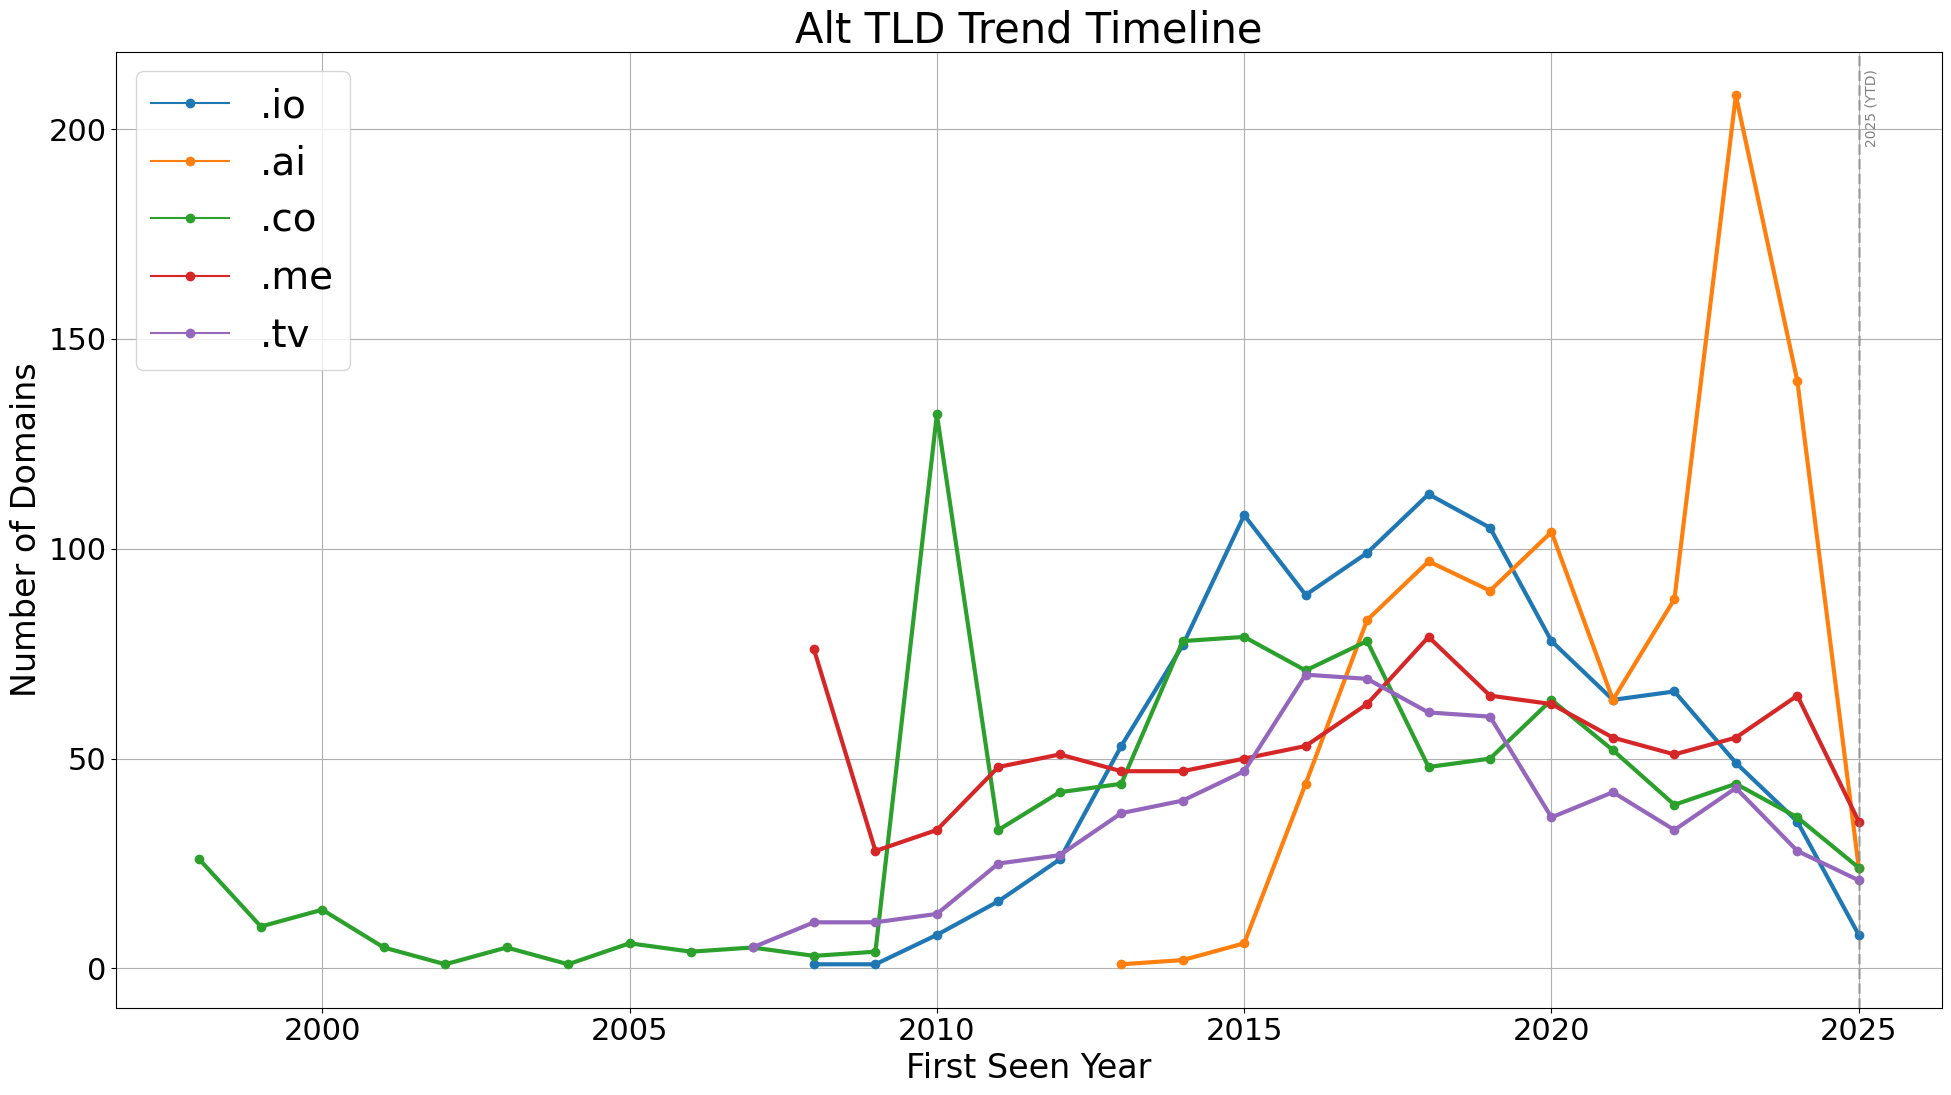

In [37]:
# Plot histograms of domains by first seen year
import matplotlib.pyplot as plt
from datetime import datetime 

# Remove noisy .io hits
cleaned_df = cleaned_df[~((cleaned_df["tld"] == "io") & (cleaned_df["first_seen_year"] < 2008))]

# Prepare the figure
plt.figure(figsize=(19.3, 10.9), dpi=100)

# Bin settings
year_bins = range(2005, int(cleaned_df["first_seen_year"].max()) + 1)
# tlds = cleaned_df["tld"].unique()    # Plot all TLDs
tlds = ["io", "ai", "co", "me", "tv"]  # Specify the TLDs you want to plot
# this_year = datetime.now().year

# Count and plot each TLD as a line
for tld in tlds:
    subset = cleaned_df[cleaned_df["tld"] == tld]
    year_counts = subset["first_seen_year"].value_counts().sort_index()
    
    # Fill in missing years with 0s to keep lines aligned
    all_years = pd.Series(index=year_bins, dtype=int)
    year_counts = all_years.add(year_counts, fill_value=0)

    plt.plot(year_counts.index, year_counts.values, marker="o", label=f".{tld}")

# Final plot tweaks
plt.xlabel("First Seen Year", fontsize=24)
plt.ylabel("Number of Domains", fontsize=24)
plt.title("Alt TLD Trend Timeline", fontsize=30)
plt.legend(prop={'size': 28})  # Increased legend font size
plt.grid(True)
plt.tight_layout()
plt.axvline(x=this_year, color="gray", linestyle="--", alpha=0.5, linewidth=2)  # Thicker vertical line
ymax = plt.gca().get_ylim()[1]
plt.text(this_year + 0.1, ymax * 0.9, f"{this_year} (YTD)", rotation=90, color="gray")
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# Set line width for all lines except the last one (which is the vertical current year line)
for line in plt.gca().lines[:-1]:
    line.set_linewidth(3)

plt.show()
